In [1]:
import estimators
from embeddings import Embedding
from gpdc import DiscreteGPDC

import numpy as np
import networkx as nx
import typing as tp

from sklearn.preprocessing import StandardScaler

In [2]:
class GPDCCommunities:
    '''
    Community search on evolving random graphs using GPDC
    '''
    def __init__(self, init_graph: nx.MultiDiGraph,
                 embedding_class: Embedding,
                 **gpdc_kwargs: tp.Any) -> None:
        '''
        Initialises base partition of an initial graph.
        :param init_graph: initial graph (nodes are expected to be integers 0, 1, ..., len(init_graph) - 1)
        '''
        self.max_node = len(init_graph)

        self.base_community = list(range(self.max_node))
        self.other_communities: list[set[int]] = []

        self.embeddings = embedding_class(init_graph)
        self.gpdc_kwargs = gpdc_kwargs

    def update(self, snapshot: nx.MultiDiGraph) -> None:
        '''
        Updates the partition.
        :param snapshot: new snapshot of a graph
        '''
        self.embeddings.update(snapshot)
        embeddings = self.embeddings.to_numpy()

        test_nodes = np.arange(self.max_node, len(snapshot))

        scaler = StandardScaler()
        train_embeddings = embeddings[self.base_community]
        test_embeddings = embeddings[test_nodes]

        # train_embeddings = scaler.fit_transform(train_embeddings)
        # test_embeddings = scaler.transform(test_embeddings)
        model = DiscreteGPDC(**self.gpdc_kwargs).fit(train_embeddings)
        
        test_results = model.predict(test_embeddings)

        new_normals = test_nodes[test_results == 1]
        new_community = test_nodes[test_results == -1]

        self.base_community.extend(new_normals)
        if len(new_community) > 0:
            self.other_communities.append(set(new_community))
            print(len(new_community))

        self.max_node = len(snapshot)

    def get_communities(self) -> list[set[int]]:
        return [set(self.base_community)] + self.other_communities

## Test simulations

In [3]:
from visualisers import visualise_communities
from linear_pa import ScaleFreeDiGraph

import embeddings

In [4]:
import random

np.random.seed(42)
random.seed(42)

Make 10000 steps of evolution, starting from one node with parameters $(0.4, 0.2, 0.4), \delta_{in} = \delta_{out} = 1$.

In [5]:
%time

init_graph = nx.MultiDiGraph()
init_graph.add_node(0)
graph = ScaleFreeDiGraph()
graph.grow(steps=10000, alpha=0.4, beta=0.2, gamma=0.4, delta_in=1, delta_out=1)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.01 μs


In [6]:
%time

detector = GPDCCommunities(init_graph=graph.get_graph(),
                           embedding_class=embeddings.PageRankInDegree,
                           tail_size=20)

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.91 μs


Plot PageRank v.s. Clustering coefficient after these steps.

In [7]:
import matplotlib.pyplot as plt

alphas = [0.3, 1, 1, 1, 1, 1]
markers = ['o', 'X', 'P', '*', 'd']
labels = ['community0', 'community1', 'community2', 'community3', 'community4']

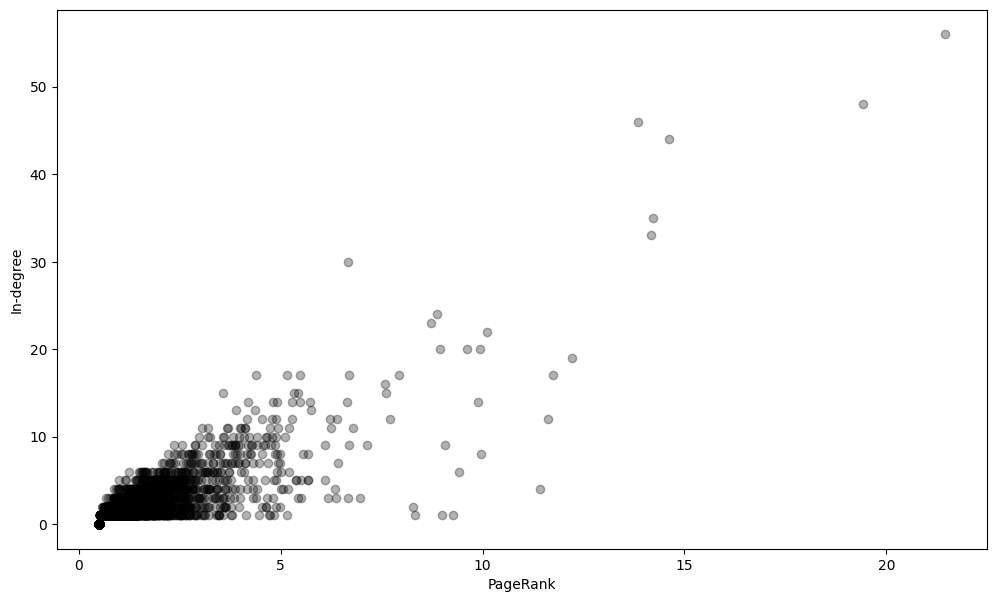

In [8]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')
plt.scatter(x=data[:, 0], y=data[:, 1], alpha=0.3, color='black')

# plt.xlim((0, 0.0005))
# plt.ylim((0, 10))

plt.show()

Make 10000 steps of evolution with parameters $(0.2, 0.3, 0.5), \delta_{in} = \delta_{out} = 1$.

In [9]:
%time

graph.grow(steps=10000, alpha=0.2, beta=0.3, gamma=0.5, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 4.29 μs
4


4 anomalies found.

In [10]:
communities = detector.get_communities()

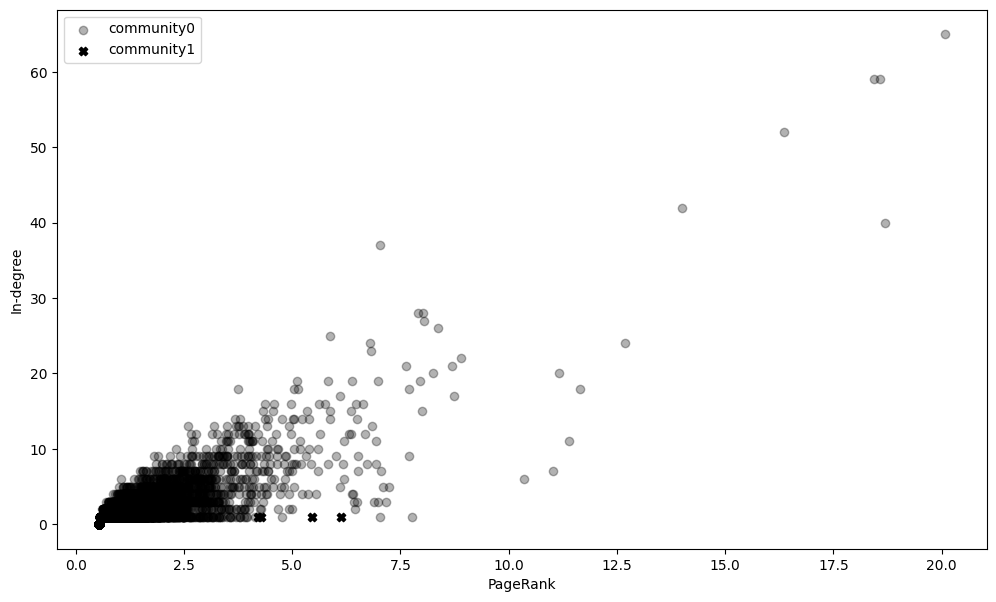

In [11]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')

for i, community in enumerate(communities):
    inds = list(community)
    plt.scatter(x=data[inds, 0], y=data[inds, 1], color='black', alpha=alphas[i], marker=markers[i], label=labels[i])

plt.legend()
plt.show()

10000 steps of evolution with parameters $(0.1, 0.3, 0.6), \delta_{in} = \delta_{out} = 1$.

In [12]:
%time

graph.grow(steps=1000, alpha=0.1, beta=0.3, gamma=0.6, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.48 μs
1


1 anomaly found.

In [13]:
communities = detector.get_communities()

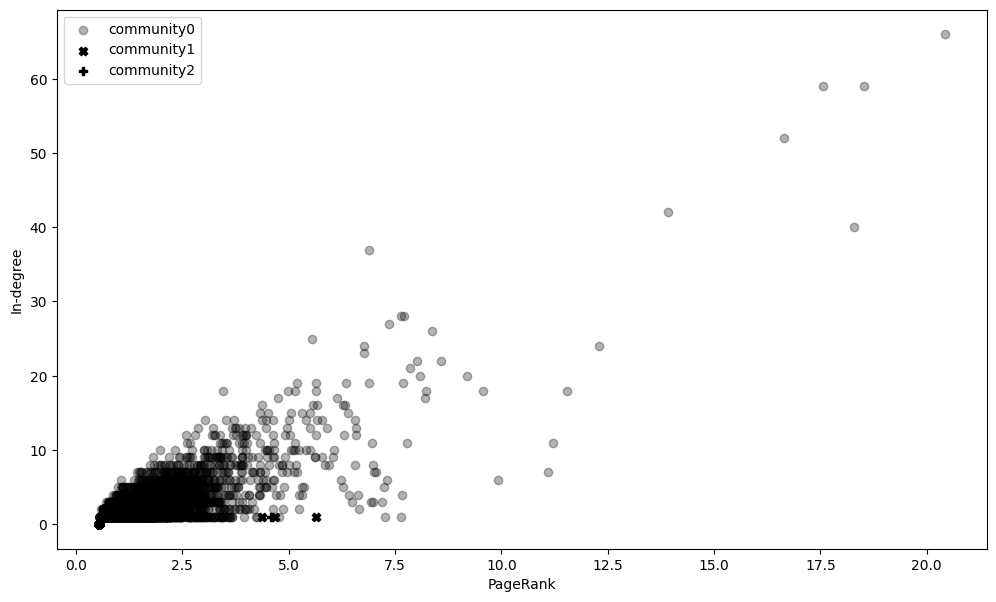

In [14]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')

for i, community in enumerate(communities):
    inds = list(community)
    plt.scatter(x=data[inds, 0], y=data[inds, 1], color='black', alpha=alphas[i], marker=markers[i], label=labels[i])

plt.legend()
plt.show()

10000 steps of evolution with parameters $(0.6, 0.1, 0.3), \delta_{in} = \delta_{out} = 1$.

In [15]:
%time

graph.grow(steps=10000, alpha=0.6, beta=0.1, gamma=0.3, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.53 μs


10000 steps of evolution with parameters $(0.6, 0.1, 0.3), \delta_{in} = \delta_{out} = 1$.

In [16]:
%time

graph.grow(steps=10000, alpha=0.6, beta=0.1, gamma=0.3, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


10000 steps of evolution with parameters $(0.6, 0.1, 0.3), \delta_{in} = \delta_{out} = 1$.

In [17]:
%time

graph.grow(steps=10000, alpha=0.6, beta=0.1, gamma=0.3, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.05 μs
7


7 anomalies found.

In [18]:
communities = detector.get_communities()

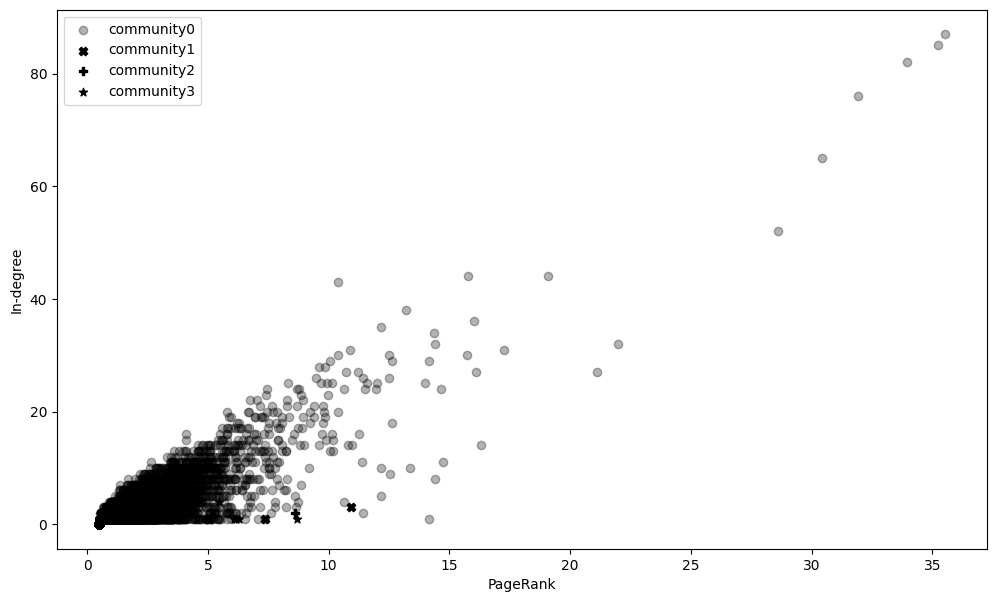

In [19]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')

for i, community in enumerate(communities):
    inds = list(community)
    # if i > 0:
    plt.scatter(x=data[inds, 0], y=data[inds, 1], color='black', alpha=alphas[i], marker=markers[i], label=labels[i])

# plt.xlim((0, 0.0012))
# plt.ylim((0, 120))

plt.legend()
plt.show()

Let's see 3 abnormal communities in the same scale.

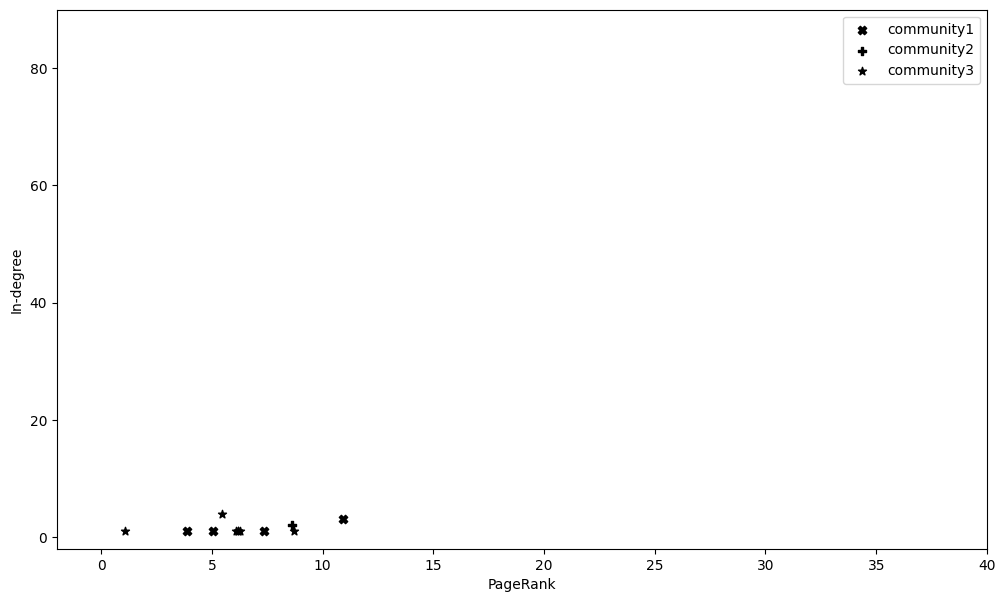

In [20]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')

for i, community in enumerate(communities):
    inds = list(community)
    if i > 0:
        plt.scatter(x=data[inds, 0], y=data[inds, 1], color='black', alpha=alphas[i], marker=markers[i], label=labels[i])

plt.xlim((-2, 40))
plt.ylim((-2, 90))

plt.legend()
plt.show()

10000 steps of evolution with parameters $(0.5, 0.1, 0.4), \delta_{in} = \delta_{out} = 1$.

In [21]:
%time

graph.grow(steps=10000, alpha=0.5, beta=0.1, gamma=0.4, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 4.77 μs
1


1 anomaly found.

10000 steps of evolution with parameters $(0.5, 0.1, 0.4), \delta_{in} = \delta_{out} = 1$.

In [22]:
%time

graph.grow(steps=10000, alpha=0.5, beta=0.1, gamma=0.4, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.01 μs


10000 steps of evolution with parameters $(0.5, 0.1, 0.4), \delta_{in} = \delta_{out} = 1$.

In [23]:
%time

graph.grow(steps=10000, alpha=0.5, beta=0.1, gamma=0.4, delta_in=1, delta_out=1)
detector.update(graph.get_graph())

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.48 μs


In [24]:
communities = detector.get_communities()

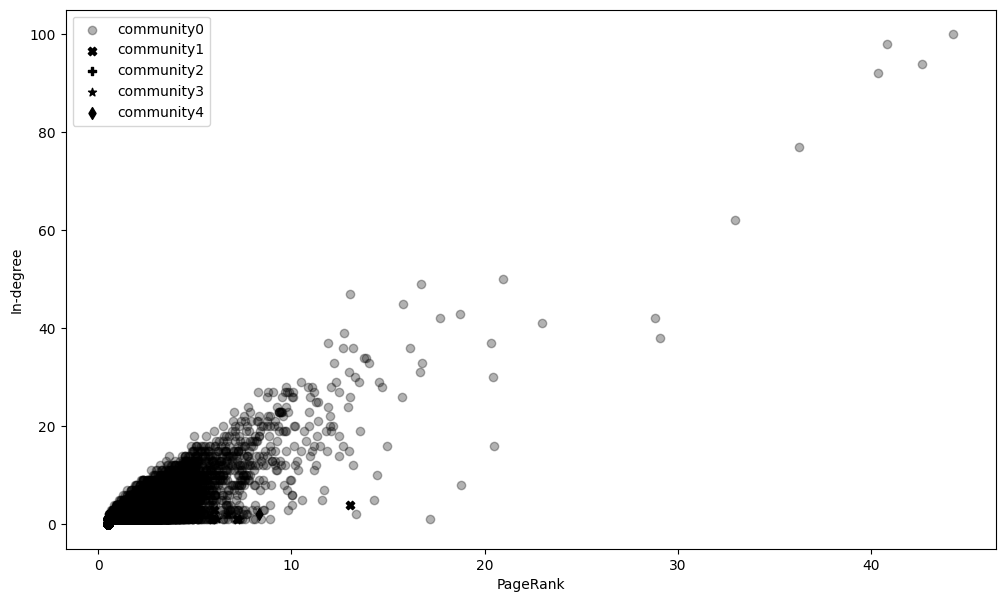

In [26]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')

for i, community in enumerate(communities):
    inds = list(community)
    # if i > 0:
    plt.scatter(x=data[inds, 0], y=data[inds, 1], color='black', alpha=alphas[i], marker=markers[i], label=labels[i])

# plt.xlim((0, 0.0012))
# plt.ylim((0, 120))

plt.legend()
plt.show()

Let's see 3 abnormal communities in the same scale.

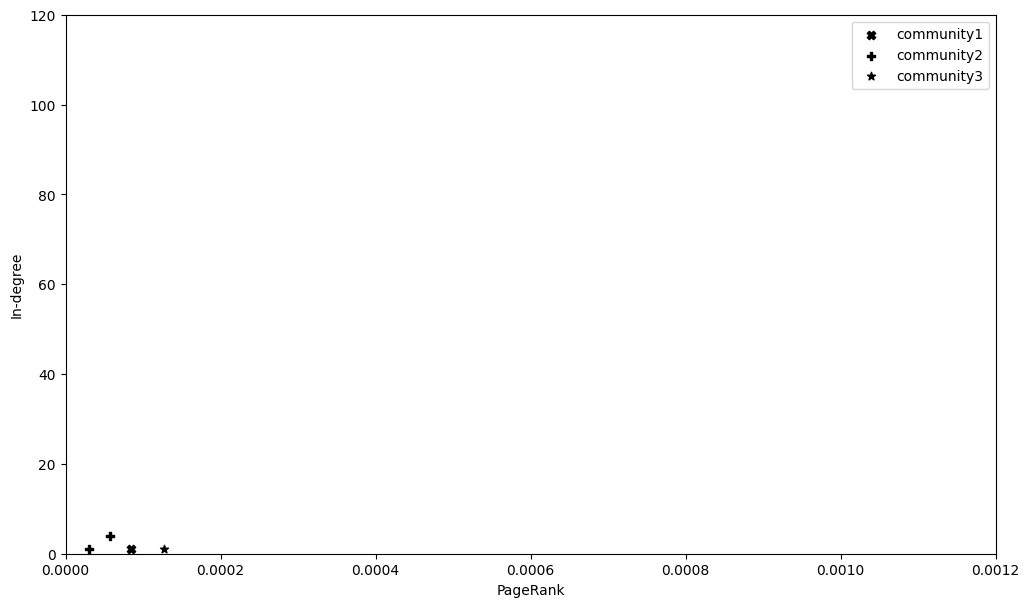

In [30]:
data = detector.embeddings.to_numpy()

plt.figure(figsize=(12, 7))

plt.xlabel('PageRank')
plt.ylabel('In-degree')

for i, community in enumerate(communities):
    inds = list(community)
    if i > 0:
        plt.scatter(x=data[inds, 0], y=data[inds, 1], color='black', alpha=alphas[i], marker=markers[i], label=labels[i])

plt.xlim((0, 0.0012))
plt.ylim((0, 120))

plt.legend()
plt.show()